# Electrocoticographic Recordings and Spectral Analysis

## Electrocorticographic recordings
Recall from week 1 that the electrical potentials emminating from the brain appear differently depending on how close the electrode is to its neurons. We generated the following figure to demonstrate this: 

![potential with distance](./images/SimulatedPotentials.png)

So far we have dealt with EEG recordings, where electrodes are placed on the scalp and can be up to 2 cm away from the sources of electrical activity in the brain. Now we will get a bit closer by examining electrocorticographic recordings (ECoG). These are obtained by placing a grid of electrodes embedded in a plastic sheet directly onto the surface of the brain. These recordings are invasive, so they are typically obtained from patients undergoing neurosurgical procedures to remove tumors or epileptic tissue. The distance with the recorded neurons has shortened to less than half a millimenter, so the middle panel above. You should notice that at the center, where a pulse of excitatory synaptic drive was delivered, in addition to the slow potential you have a burst of higher frequency activity. This reflects activity localized near the electrode, and in ECoG recordings reflects some spiking [CITE], along with locally generated synchronized bursts of synaptic activity [CITE]. These activities will not be precisely time-locked to the excitatory stimulus, varying because the spiking of individual neurons is probabilistic.

Due to their local nature, the high frequency activity in the ECoG grid reflects the processing carried in a restricted region of cortex ([~3mm](https://www.jneurosci.org/content/39/22/4299.abstract)). Since different areas of cortex tend to process different types of information, a grid of ECoG electrodes can record activities with greater specifity for stimulus and behavioral events. We will take advantage of this with the example dataset used for the following weeks.

## ECoG recording from motor cortex
The motor cortex supports the production of purposeful movements. In humans, it is present immediately anterior (in front of) to the central sulcus (a large ridge) that runs out from the midline laterally. It is organized in a 'somatotopic' manner, where parts of the body that are near each other are represented in nearby areas on the cortical surface. The feet and legs are closest to the midline, followed by the torso, arms and hands streching laterally, then face and mouth on the lateral edge. The area of cortex devoted to the hand is especially enlarged, with representations of individual fingers arrayed across the cortical surface.

[FIGURE OF MOTOR CORTEX]

This map of the body surface across the motor cortex provides an opportunity for BCI. If an ECoG grid is placed over motor cortex, it is possible to record from brain areas controlling fingers. Primates are especially adept at controlling individual fingers, so the area of motor cortex that controls them may be ammenable to controlling a prosthetic device (e.g. a robotic arm or cursor on a computer screen).

We for the next few weeks we will work with dataset containing ECoG recordings that encompass the motor cortex. They are from patients undergoing clinical monitoring to identify the area of brain tissue that is the source of epileptic seizures. Patients first have a portion of their skull removed (known as a craniotomy), their dura peeled back (known as a durotomy) and a grid of electrodes is laid on the surface of their brain. The skull is then closed up and the patients stay at the hospital while their brain activity is continuously monitored. During that time, researchers can work with these patients to study brain function in humans.

For this study, subjects had the ECoG grid placed over the motor cortex. They wore a glove with sensors attached to it that could detect the flexion of each finger. A computer screen was placed in front of them and every 2 seconds a word was displayed indicating which finger to move. These were separated by 2 second rest periods.

We will attempt to decode which finger was moved. To do this, we need to cover three topics. First, this week we will discuss spectral analysis, which is used to extract the localized high frequency activity in the ECoG signal. Second, we will take these spectral measurements across multiple electrodes and learn how to design logistic models that use multiple features to classify. Last, we will learn how to pool together logistic models to predict multiple categories of events, in this case which finger was flexed.

## Loading ECoG and finger flexion data

To start, let's load the recorded data. The dataset we are working with comes from the 'fingerflex.zip' dataset found [here](https://exhibits.stanford.edu/data/catalog/zk881ps0522). Other ECoG data sets can be found that use [visual stimuli](https://openneuro.org/datasets/ds004194/versions/1.0.1). There is also a BCI competition with several freely available datasets that also include EEG and MEG recordings [here](https://www.bbci.de/competition/iv/).

We will use the scipy package for much of this week, so let's load the relevant packages.

In [97]:
import sys
sys.path.append('..')
import os.path as op
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy.signal as ss
import scipy.stats as st
import scipy.ndimage as sn
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from nilearn import plotting
from nimare import utils
from source.ERPDecoders import ERP_Decode_SK

The ECoG and finger flexion data is found in the file with the suffix '_fingerflex.mat'. We can load it using the `loadmat` function from the `scipy.signal` package.

In [2]:
# load data files
subj = 'cc'
ecog_path = ['.', 'data', subj, '{}_fingerflex.mat'.format(subj)]
ecog_file = op.join(*ecog_path) # use * to unpack the list
data = sio.loadmat(ecog_file)

# recording parameters
fs = 1000
t = np.arange(data['data'].shape[0]) / fs
ch = np.arange(data['data'].shape[1])

Examining the data in `ecog`, we have several relevant fields.

In [3]:
# list the keys and data types in the dictionary
for key, val in data.items():
    print("{}".format(key))
    if isinstance(val, np.ndarray):
        print("\t{}, {}".format(val.dtype, val.shape))
    else:
        print("\t{}".format(type(val)))

__header__
	<class 'bytes'>
__version__
	<class 'str'>
__globals__
	<class 'list'>
data
	int32, (610040, 63)
elec_regions
	uint8, (63, 1)
flex
	uint16, (610040, 5)
brain
	[('vert', 'O'), ('tri', 'O')], (1, 1)
locs
	float64, (63, 3)
cue
	uint8, (610040, 1)


The `data` field contains the recordings from the ECoG electrode array. It is stored as a numpy array with time across rows and electrodes along columns. 63 channels were recorded, and with a 1 kHz sample rate the recording duration was 610050/1000 = 610 s or approximately 10 minutes. 

Finger flexion information is stored in the `flex` field. It has time across rows, and fingers across columns.

Also provided is a `locs` field, which indicates the location of ECoG electrodes on the brain. We can use the `nilearn` and `nimare` package to visualize these overlaid on a standard brain model.

In [4]:
# plot location of ECoFG electrodes
# code from https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/ECoG/load_ECoG_fingerflex.ipynb#scrollTo=tD75j3xqzMh9
plt.figure(figsize=(8, 8))
locs = data['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

We can see the electrodes laid out in a grid over the grayed out surface of the brain. Approximately along the middle of the grid is motor cortex, which contains the activities we want to probe when subjects flex their fingers.

The finger flexion data is stored in the field `flex`. It is a numpy array with time along the row dimension and fingers along the column dimension (hence 5 columns). Since we want to examine the finger activity associated with finger flexion, we need to extract the times when finger flexing occurs. Visualizing this signal is the first step to creating an algorithm to extract these periods.

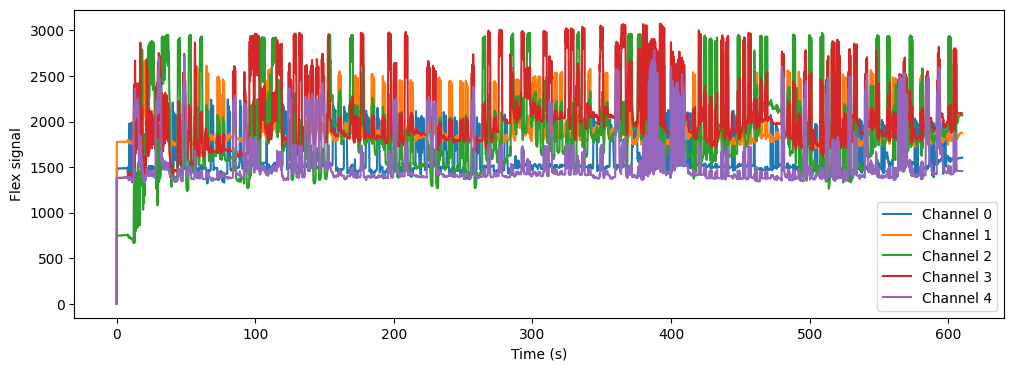

In [5]:
flex = data['flex']

# plot the raw data
plt.figure(figsize=(12, 4))
plt.plot(t, flex)
plt.xlabel('Time (s)')
plt.ylabel('Flex signal')
plt.legend(['Channel {}'.format(k) for k in np.arange(flex.shape[1])])
plt.show()


Well this is hard to read, but a few things stand out. First, the signals show different offsets, so we probably want to remove the mean. The baseline for channels 1 and 2 are higher than 0 and 4.  Also note that the range of values for the signals tend to differ. Channels 1 and 0 seem to have shorter deflections than the other ones. A simple way to make all the baselines equivalent and rescale the deflections is to *z-score* each signal. To z-score a signal, we subtract from it its mean and then divide by its standard deviation. This can be expressed mathematically as:

$$ zscore = \frac{X-E[X]}{SD[X]} $$

Here X is the signal, $E[X]$ is its mean, and $SD[X]$ is the standard deviation. Z-scoring transforms the data so that the value at each time point is now in terms of standard deviations from the mean. Generally that means that extreme values, such as the deflections we see, will not exceed a value of 5 (5 standard deviations from the mean).

We can implement this as a function using numpy functions. Then we can apply it to our flexion data.

In [6]:
# create zscore function with dimension parameter
def zscore(x, dim):
    return (x - np.mean(x, axis=dim, keepdims=True))/np.std(x, axis=dim, keepdims=True)

# zscore the data
zflex = zscore(flex, 0)

To visualize multichanel data, it is usually a good to separate out the channels along the y-axis, so that they do not overlap. Since the signals are z-scored, we can set a separation of 5 standard deviations between each trace.

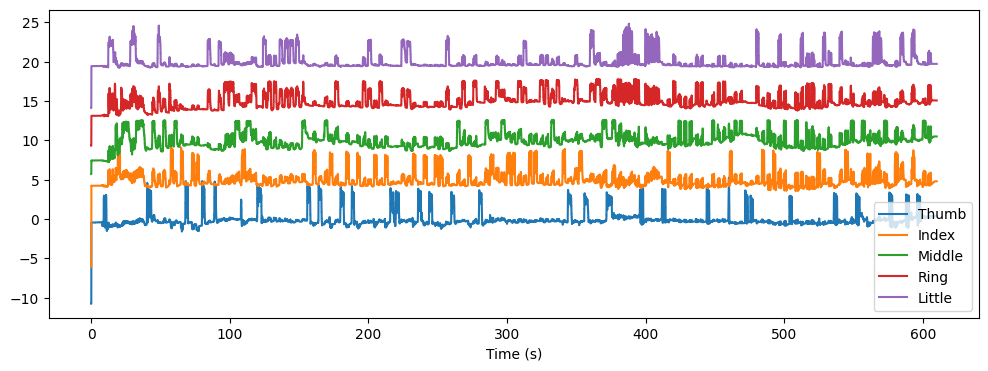

In [7]:
def plot_stacked_signals(sig, t, sep=5, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    for i in range(sig.shape[1]):
        ax.plot(t, sig[:, i] + i*sep, **kwargs)
    ax.set_xlabel('Time (s)')
    ax.legend()
    return ax

plt.figure(figsize=(12, 4))
plot_stacked_signals(zflex, t)
plt.legend(['Thumb', 'Index', 'Middle', 'Ring', 'Little'])

The signals looks fairly equalized now. We can see that for channel 0, the thumb, there is a well defined deflection with consistent height. The is also mostly true for the little finger, on channel 4. This is less the case for the index finger, which is showing modest deflections that are associated with deflections of either the middle or ring fingers. This means decoding flexion of the middle and ring fingers would prove difficult, since we cannot adequately isolate them. Instead, we will focus on the thumb, index, and little fingers.

To detect flexions, we need to set a threshold. Again, plotting the signals will help with this. Let's now plot just the fingers we intend to decode, and in a smaller time window so we can see how the signal fluctuates during deflections.

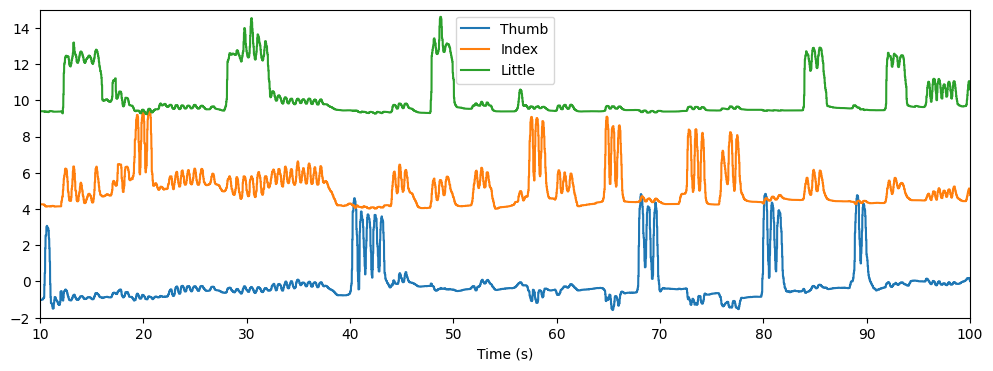

In [8]:
plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
ax.set_ylim([-2, 15])
ax.set_xlim([10, 100])
ax.legend(['Thumb', 'Index', 'Little'])

Now we can see things more clearly. Each flexion event is actually a quick series of flexions, usually 3 in a row. It is that period we want to detect. The simplest way to do this is to set a threshold. We can then plot the detection signals overtop the flexion traces. 

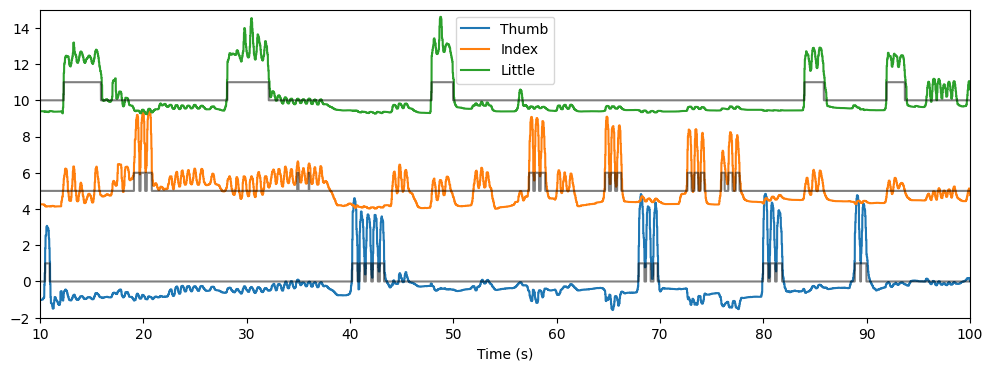

In [9]:
dflex = zflex>1.5

plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(dflex[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.set_ylim([-2, 15])
ax.set_xlim([10, 100])
ax.legend(['Thumb', 'Index', 'Little'])

The detected flexion signals are transparent black lines layered on top the flexion traces. These seem to be pretty good except for two issues. First, during a flexion burst there are periods where the signal drops below the threshold, so we want to eliminate those. Second, occasionally the index finger detection briefly occurs spuriously, for instance around 35 seconds. We can use *morphological binary opening* and closing operations to fix these.

For our purposes, you can think of a binary open operation as applying a filter to an array of binary data that sets to 0 (false) areas of 1s (trues) that are smaller than a preset size. For instance:

In [10]:
test_bin = np.array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1])
test_bin_open1 = sn.binary_opening(test_bin, structure=np.ones(1))
test_bin_open2 = sn.binary_opening(test_bin, structure=np.ones(2))
test_bin_open3 = sn.binary_opening(test_bin, structure=np.ones(3))

# print, right justified
print("test_bin:      {}".format(test_bin.astype(int)))
print("test_bin_open1:{}".format(test_bin_open1.astype(int)))
print("test_bin_open2:{}".format(test_bin_open2.astype(int)))
print("test_bin_open3:{}".format(test_bin_open3.astype(int)))


test_bin:      [0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1]
test_bin_open1:[0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1]
test_bin_open2:[0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0]
test_bin_open3:[0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]


The `structure` argument is the filter. For a 1d array, and if the filter is a list of 1s, then the length of the filter determines the minimum size allowed for a contiguous block of 1s. You can see that a filter of `[1]` nothing changes. When the filter is `[1,1]`, then any single 1s are removed. For a filter of `[1,1,1]` we remove blocks of 1s that are just two next to each other.

Using this, we should be able to eliminate the spurious deflections on the index finger.

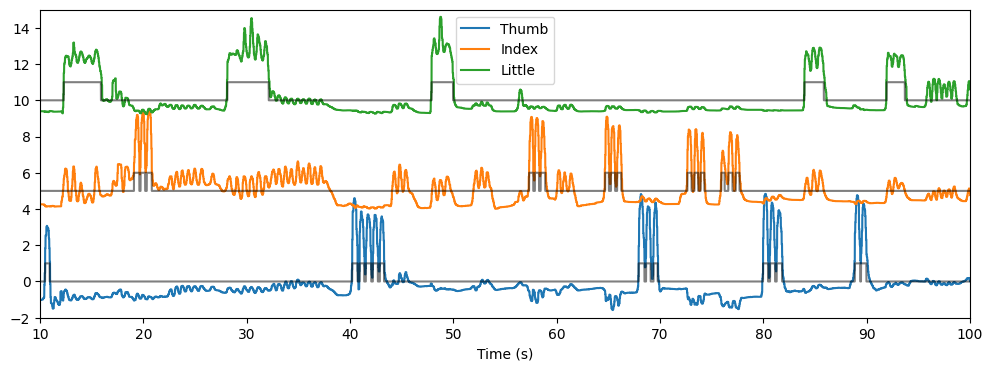

In [11]:
close_struct = np.ones([200,1]) # 200 ms, given the sampling rate of 1000 Hz
dflex_open = sn.binary_opening(dflex,close_struct)

plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(dflex_open[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.set_ylim([-2, 15])
ax.set_xlim([10, 100])
ax.legend(['Thumb', 'Index', 'Little'])

Yay, we eliminated those spurious deflections. Next we want to group together groups of deflections. For this we use the *morphological binary closing* operation. Imagine this as the opposite of the opening operation. In this case, areas of 0s (bordered by 1s) that are smaller than the filter size are replaced with 1s.

In [12]:
test_bin_close1 = sn.binary_closing(test_bin, structure=np.ones(1))
test_bin_close2 = sn.binary_closing(test_bin, structure=np.ones(2))
test_bin_close3 = sn.binary_closing(test_bin, structure=np.ones(3))

# print, right justified
print("test_bin:       {}".format(test_bin.astype(int)))
print("test_bin_close1:{}".format(test_bin_close1.astype(int)))
print("test_bin_close2:{}".format(test_bin_close2.astype(int)))
print("test_bin_close3:{}".format(test_bin_close3.astype(int)))

test_bin:       [0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1]
test_bin_close1:[0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1]
test_bin_close2:[0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1]
test_bin_close3:[0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0]


Here you can see that closing with a filter of `[1]` has no effect, just like the opening operation. For `[1,1]`, spots were only 2 zeros were present are infilled with 1s. And with `[1,1,1]`, spots with two contiguous 0s are now infilled with 1s.

Let's apply it to the flexion data.

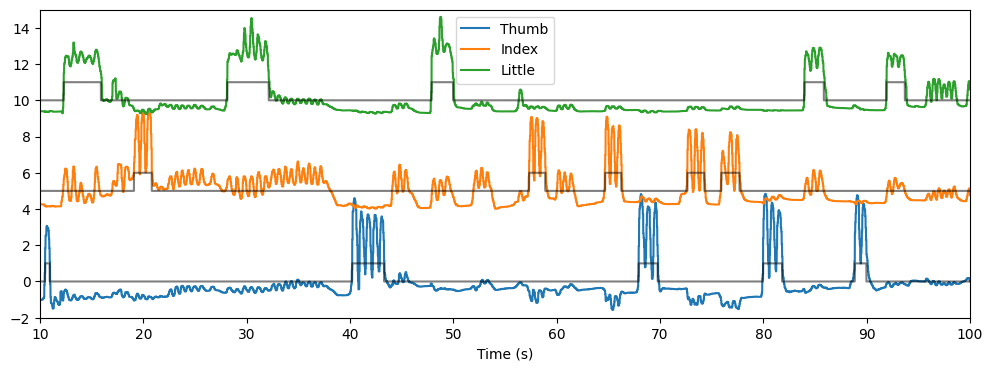

In [13]:
open_struct = np.ones([500,1]) # 500 ms, given the sampling rate of 1000 Hz
dflex_open_closed = sn.binary_closing(dflex_open,open_struct)

plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(dflex_open_closed[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.set_ylim([-2, 15])
ax.set_xlim([10, 100])
ax.legend(['Thumb', 'Index', 'Little'])

Looking good now! The periods of deflections are are contiguous and we have eliminated spurious ones. Let's package all of this into a function that accepts flexion data and returns the series of detected deflections.

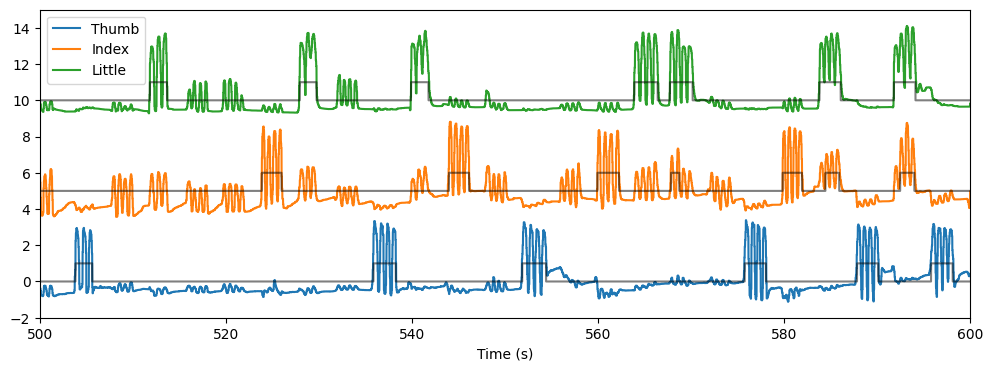

In [14]:
def detect_flex_events(sig, thresh=1.5, min_duration=200, max_spacing=500):
    """
    Detects events in a flex signal.
    
    Parameters
    ----------
    flex_sig : array_like
        The flex signal to detect events in.
    thresh : float
        The threshold to use for event detection.
    min_duration : int
        The minimum duration of an event (in samples).
    max_spacing : int
        The maximum spacing between events (in samples).
        
    Returns
    -------
    events : array_like
        Binary array.
    """
    # 1. get the z-scored flex signal
    z_sig = zscore(sig, dim=0)
    # 2. detect when signal crosses a threshold
    events = z_sig > thresh
    # 3. remove events shorter than min duration
    events = sn.binary_opening(events, structure=np.ones([min_duration,1]))
    # 4. combine events spaced too closely together
    events = sn.binary_closing(events, structure=np.ones([max_spacing,1]))
    return events.astype(int) # convert to int for numpy operations

# detect events
flex_events = detect_flex_events(flex)

# plot the events
plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(flex_events[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.set_ylim([-2, 15])
ax.set_xlim([500, 600])
ax.legend(['Thumb', 'Index', 'Little'])

Plotting a different time window, we can see that the index and little fingers occasionally share the same deflection periods, especially between 580 and 600 s. To minimize that, we can try raising the threshold a little.

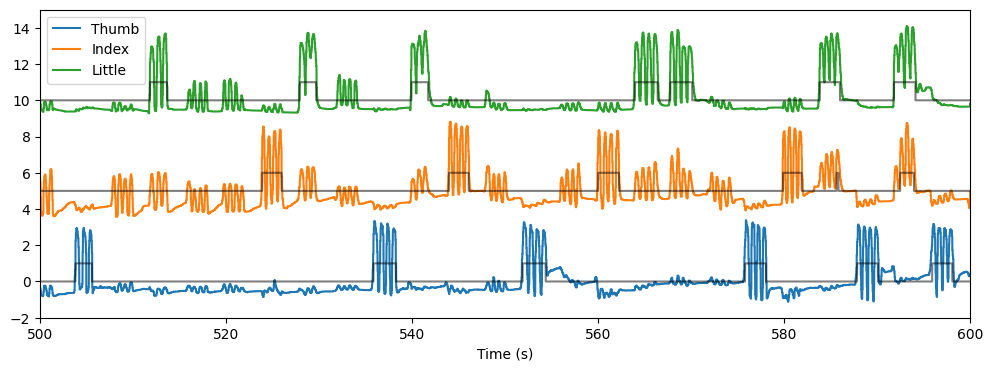

In [15]:
# detect events
flex_events = detect_flex_events(flex, thresh = 2, min_duration = 200)

# plot the events
plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(flex_events[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.set_ylim([-2, 15])
ax.set_xlim([500, 600])
ax.legend(['Thumb', 'Index', 'Little'])

Tweaking the detection parameters minimized the problem. So from here out we will use the `flex_events` time series to determine where finger movements occured.

Now that we can detect the times when finger deflections start, we want to identify which electrodes have activities associated with them. To start, we will look for ERPs, similar to how we did in previous weeks. We will trigger these off the start times of each finger flexion burst.

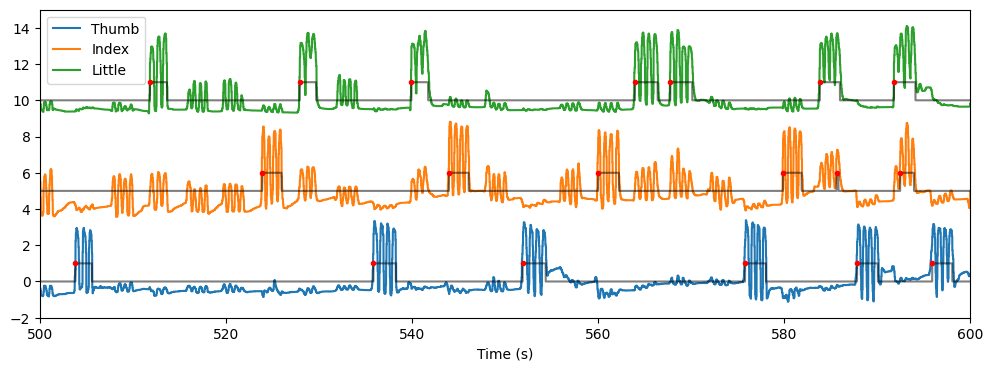

In [16]:
thumb_starts = np.where(np.diff(flex_events[:, 0]) == 1)[0] + 1
index_starts = np.where(np.diff(flex_events[:, 1]) == 1)[0] + 1
little_starts = np.where(np.diff(flex_events[:, 4]) == 1)[0] + 1

# plot the start events
plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(flex_events[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.plot(t[thumb_starts], flex_events[thumb_starts, 0], 'r.')
ax.plot(t[index_starts], flex_events[index_starts, 1]+5, 'r.')
ax.plot(t[little_starts], flex_events[little_starts, 4]+10, 'r.')
ax.set_ylim([-2, 15])
ax.set_xlim([500, 600])
ax.legend(['Thumb', 'Index', 'Little'])



Let's visualize the ECoG signal, to see if we have to do any preprocessing on it. Recall that for the EEG signal we had to remove a slow basline drift, EMG, 60 Hz noise, and EOG. Do these artifacts occur in the new data set? We will peak at the first 10 channels to see.

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


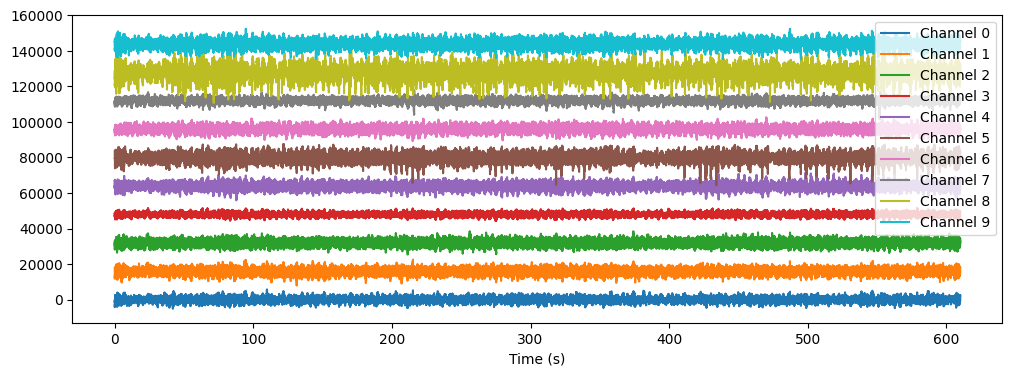

In [17]:
ecog = data['data']

# plot ecog signal
plt.figure(figsize=(12, 4))
plot_stacked_signals(ecog[:,:10], t, sep=16000)
plt.legend(['Channel {}'.format(k) for k in np.arange(10)])

Thankfully, there is no obvious drift here, so we don't need to remove that. There are some sharp deflections on channels 4 and 5, but they are not shared with other electrodes so it is unlikely that they reflect electro-oculogram artifacts. Perhaps 60 Hz noise is present. It is hard to see when viewing the entire recording session, so let's zoom in.

(500.0, 502.0)

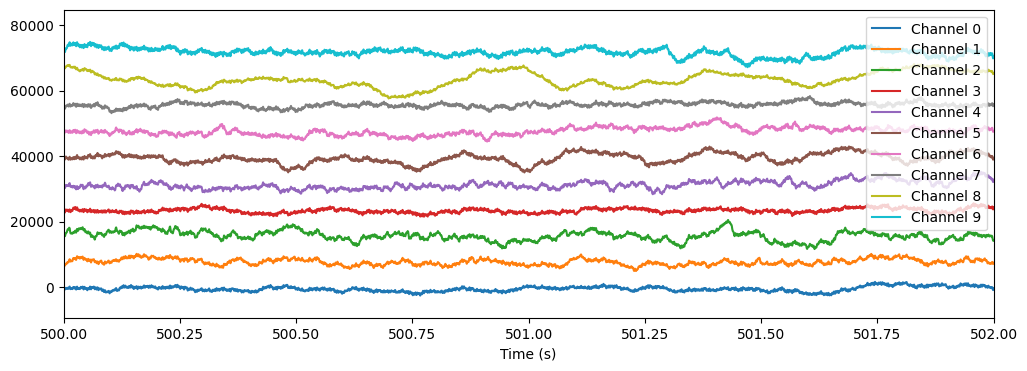

In [18]:
# plot ecog signal
plt.figure(figsize=(12, 4))
plot_stacked_signals(ecog[:,:10], t, sep=8000)
plt.legend(['Channel {}'.format(k) for k in np.arange(10)])
plt.xlim([500, 502])

No obvious 60 Hz noise here. Infact, this data has already been preprocessed to remove it. As for EMG, we will not attempt to filter that out because subsequent analyses will depend on neural signals above 60 Hz, which was the cutoff we used for removing EMG data in our EEG dataset.

Working with the signal as is, let's get the ERP on each electrode in response to finger deflections.

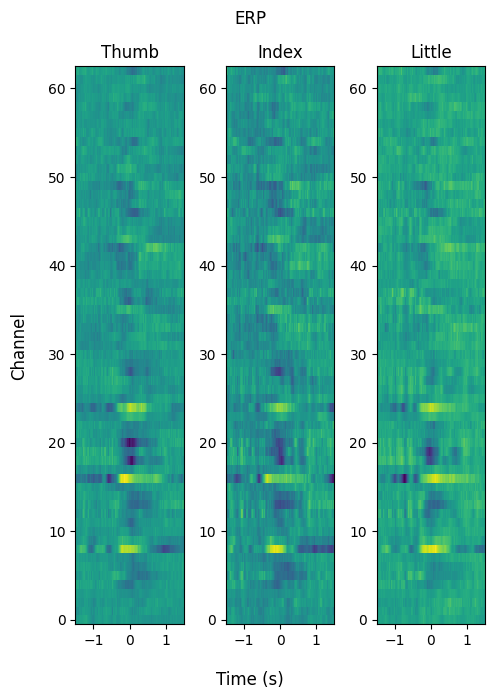

In [19]:
def calc_ecog_erp(sig, events, pre=1.5, post=1.5):
    """
    Calculates the ERP for a given signal and set of events.
    
    Parameters
    ----------
    sig : array_like
        The signal to calculate the ERP for.
    events : array_like
        The events to calculate the ERP for.
    pre : float
        The time (in seconds) before the event to include in the ERP.
    post : float
        The time (in seconds) after the event to include in the ERP.
    
    Returns
    -------
    erp : array_like
        The ERP.
    t : array_like
        The time vector for the ERP.
    """

    # convert pre and post to samples
    pre = int(1.5*fs)
    post = int(1.5*fs)
    t = np.linspace(-pre, post, pre+post)

    # get epochs
    erp = []
    for i, o in enumerate(events):
        erp.append(sig[(o-pre):(o+post), :])

    # stack epochs and average
    erp = np.stack(erp, axis=2)
    erp = np.mean(erp, axis=2)

    return erp, t/fs

# calculate the ERPs
erp_thumb, t_erp = calc_ecog_erp(ecog, thumb_starts)
erp_index, _ = calc_ecog_erp(ecog, index_starts)
erp_little, _ = calc_ecog_erp(ecog, little_starts)

# plot the ERPs
fig, ax = plt.subplots(1, 3, figsize=(5, 7)) 
ax[0].pcolormesh(t_erp, ch, erp_thumb.T)
ax[0].set_title('Thumb')
ax[1].pcolormesh(t_erp, ch, erp_index.T)
ax[1].set_title('Index')
ax[2].pcolormesh(t_erp, ch, erp_little.T)
ax[2].set_title('Little')
fig.suptitle('ERP')
fig.supxlabel('Time (s)')
fig.supylabel('Channel')
fig.tight_layout()
plt.show()

Well that is interesting, it appears that we have a consistent set of channels that are activated across fingers. Notice that the pattern appears to repeat across channels. This might reflect the grid pattern of the ECoG array, with a cluster of sites near each other showing the strongest activation.

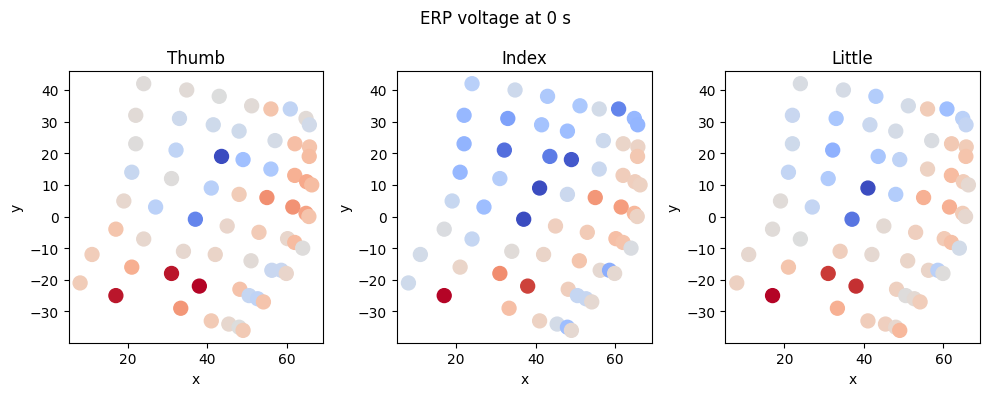

In [20]:
# plot locs colored by erp
def erp_grid(locs, erp, t, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(locs[:, 0], locs[:, 1], c=erp[t,:], cmap='coolwarm', s=100)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return ax

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
erp_grid(locs, erp_thumb, 1500, ax=ax[0])
ax[0].set_title('Thumb')
erp_grid(locs, erp_index, 1500, ax=ax[1])
ax[1].set_title('Index')
erp_grid(locs, erp_little, 1500, ax=ax[2])
ax[2].set_title('Little')
fig.suptitle('ERP voltage at 0 s')
fig.tight_layout()

Broadly the same pattern is present across the grid for the ERP in response to different finger movements. But, there are some subtle differences which can be exploited down the line by feeding multiple channels into our decoder. 

To get a better grasp of the activity, let's plot the ERP from the channel with a strong negative deflection.

Text(0.5, 1.0, 'Thumb ERP at channel 20')

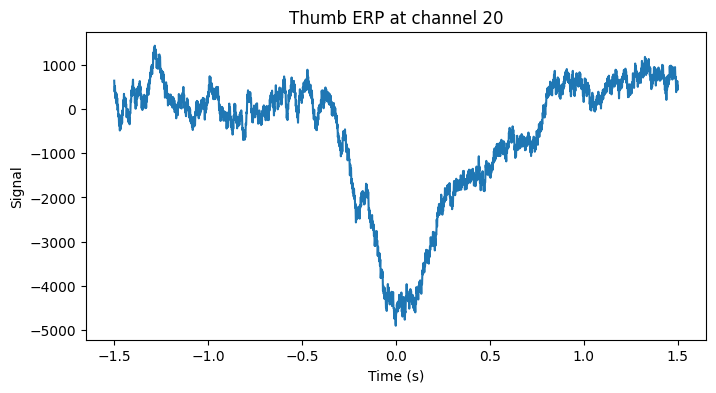

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(t_erp, erp_thumb[:, 20])
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Thumb ERP at channel 20')

Notice that at the trough of this ERP, we see a burst of high frequency activity, as we did in our simulations in week 1 that we returned to above. To analyze this signal, we will now turn to spectral analysis. It might be easiest to start by showing end point of this analysis, and then working towards it for the rest of this lecture. 

We will calculate the *spectrogram* of our ECoG signal, which takes a time series and breaks it apart into separate frequency bands with varying amplitude across time. Then, just as with the ERP, we can calculate the mean spectral response centered on a finger movement. Let's do this for channel 20.

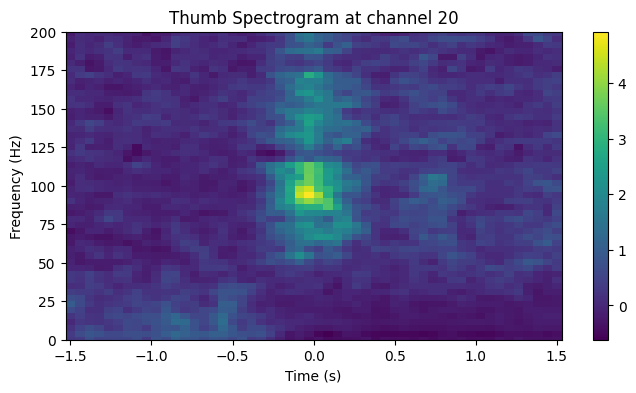

In [22]:
# calculate spectrogram
freqs, t_spec, s = ss.spectrogram(ecog[:, 20], fs, nperseg=256, noverlap=200, window='hamming')
fs_spec = 1/np.mean(np.diff(t_spec))

# zscore the spectrogram so all frequencies are on the same scale
s = zscore(s, 1)

# create a new array of fl events at the time points closest to those in the spectrogram data
thumb_starts_spec = np.zeros(thumb_starts.shape).astype(int)

for i,t in enumerate(thumb_starts/fs):
    thumb_starts_spec[i] = np.argmin(np.abs(t_spec-t))

# calculate the mean spectrogram for thumb events
pre = int(1.5*fs_spec)
post = int(1.5*fs_spec)
thumb_spec = []
for i, o in enumerate(thumb_starts_spec):
    thumb_spec.append(s[:, o-pre:o+post])
thumb_spec = np.stack(thumb_spec, axis=2)
thumb_spec_mean = np.mean(thumb_spec, axis=2)

# plot the spectrogram
t_spec_win = np.linspace(-1.5, 1.5, pre+post)
plt.figure(figsize=(8, 4))
plt.pcolormesh(t_spec_win, freqs, thumb_spec_mean)
plt.ylim([0, 200])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Thumb Spectrogram at channel 20')
plt.colorbar()

Notice the bright spot right before the thumb movement onset, and at frequencies between 50 and 150 Hz. This high frequency activity reflects localized processing, a combination of spiking activity and locally generated fast oscillations. Numerous studies have found this high frequency activity when movements are initiated. In addition, you may notice a coincident decrease in low frequency activity, below 25 Hz. That too is a well established neural correlate of movement, known as *event-related desynchronization*. 

These high frequency bursts are even evident on individual trials.

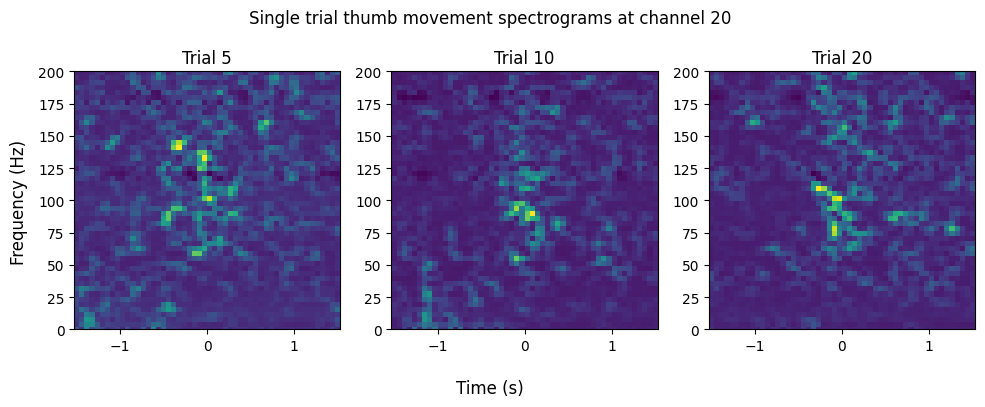

In [38]:
# plot individual trials
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
for i, ind in enumerate([5, 10, 20]):
    ax[i].pcolormesh(t_spec_win, freqs, thumb_spec[:,:,ind])
    ax[i].set_ylim([0, 200])
    ax[i].set_title('Trial {}'.format(ind))
fig.suptitle('Single trial thumb movement spectrograms at channel 20')
fig.supxlabel('Time (s)')
fig.supylabel('Frequency (Hz)')
fig.tight_layout()


The high frequency bursts occur as strong, but sporadic, events that cluster around movement onset. 

Now that we know what we want to detect, lets go over the basics of spectral analysis so you understand where they come from.

## Spectral analysis basics

The starting point of spectral analysis is the fact that any signal can be broken down into a sum of sinusoidal waves. To refresh, a sinusoid is a periodic function that flucuates between positive and negative peaks, repeating itself over and over every $2\pi$ steps along the x-axis.

Text(0.5, 1.0, 'Sinusoid')

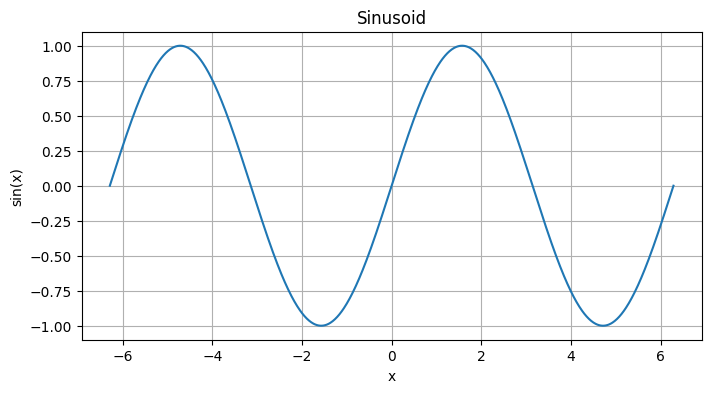

In [40]:
# plot a sinusoid
plt.figure(figsize=(8, 4))
x = np.linspace(-2*np.pi, 2*np.pi, 1000)
plt.plot(x, np.sin(x))
plt.grid()
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('Sinusoid')

We can modify a sinusoid wave in three ways, illusrated by the following equation:

$$ y = Asin(fx2\pi+p) $$

$A$ controls the *amplitude*, allowing the sine wave to peak at values greater or less than 1/-1. Next is $f$, which controls the frequency. The frequency determines how many cycles of the wave occur per a step of 1 along the x-axis. To get the increments in terms of steps of 1, we multiply $x$ by $2\pi$. Last is $p$, which shifts the sinusoid forward or backward. It is also known as the phase offset. See the visualizations of these three parameters.

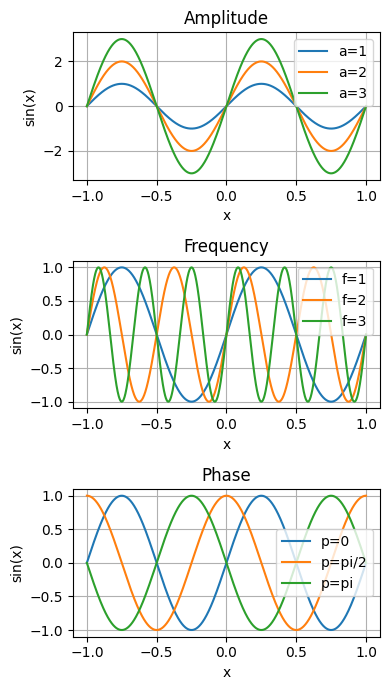

In [49]:
sin_func = lambda x,a,f,p : a*np.sin(2*np.pi*f*x + p)
x = np.linspace(-1, 1, 1000)
# Create 3 subplots, each with 3 different sine waves where one parameter is varied. The first subplot will be amplitude, second will be frequency, and third will be phase.
fig, ax = plt.subplots(3, 1, figsize=(4, 7))
ax[0].plot(x, sin_func(x, 1, 1, 0))
ax[0].plot(x, sin_func(x, 2, 1, 0))
ax[0].plot(x, sin_func(x, 3, 1, 0))
ax[0].set_xlabel('x')
ax[0].set_ylabel('sin(x)')
ax[0].set_title('Amplitude')
ax[0].legend(['a=1', 'a=2', 'a=3'])
ax[0].grid()
ax[1].plot(x, sin_func(x, 1, 1, 0))
ax[1].plot(x, sin_func(x, 1, 2, 0))
ax[1].plot(x, sin_func(x, 1, 3, 0))
ax[1].set_xlabel('x')
ax[1].set_ylabel('sin(x)')
ax[1].set_title('Frequency')
ax[1].legend(['f=1', 'f=2', 'f=3'])
ax[1].grid()
ax[2].plot(x, sin_func(x, 1, 1, 0))
ax[2].plot(x, sin_func(x, 1, 1, np.pi/2))
ax[2].plot(x, sin_func(x, 1, 1, np.pi))
ax[2].set_xlabel('x')
ax[2].set_ylabel('sin(x)')
ax[2].set_title('Phase')
ax[2].legend(['p=0', 'p=pi/2', 'p=pi'])
ax[2].grid()
fig.tight_layout()

Recall how we identified the degree of fit between the EEG and the ERP by convolving them (taking their dot product). We can measure the degree to which a signal contains a reference sine wave at a specific frequency by convolving it with the signal. Below we create a reference sine with a frequency of 1 and phase offset of 0, and explore its dot products with sine wave signals that vary in their amplitude, frequency, and phase offset. We will refer to this dot product as $a$:

$$ a = y \cdot sin(2\pi ft) $$

where $y$ is the signal we are assessing for the presence of the sine wave.

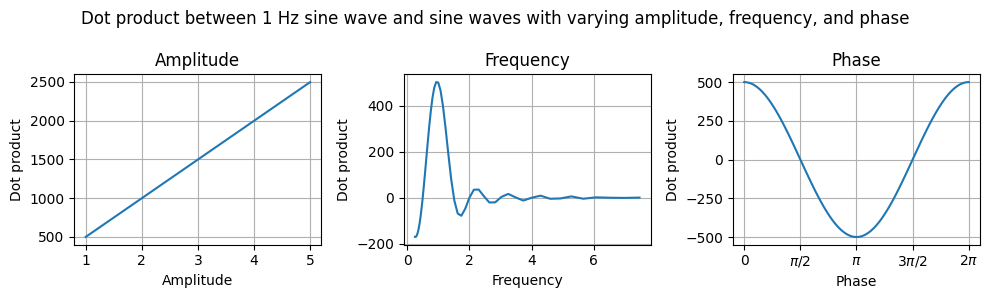

In [81]:
# quantify the dot product between a 1 Hz sine wave and: 1. sine waves of the same frequency but different amplitudes, 2. sine waves of different frequencies but the same amplitude, 3. sine waves of the same frequency and amplitude but different phases.
cos_func = lambda x,a,f,p : a*np.cos(2*np.pi*f*x + p)
x = np.linspace(0, 1, 1000)
ref_sin = sin_func(x, 1, 1, 0) # 1 Hz sine wave

# 1. amplitude
var_a = [np.dot(ref_sin, sin_func(x, a, 1, 0)) for a in range(1, 6)]
var_f = [np.dot(ref_sin, sin_func(x, 1, f, 0)) for f in np.power(2.0, np.arange(-2, 3, 0.1))]
var_p = [np.dot(ref_sin, sin_func(x, 1, 1, p)) for p in np.linspace(0, 2*np.pi, 100)]

# plot the dot products
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].plot(range(1, 6), var_a)
ax[0].set_xlabel('Amplitude')
ax[0].set_ylabel('Dot product')
ax[0].set_title('Amplitude')
ax[0].grid()
ax[1].plot(np.power(2.0, np.arange(-2, 3, 0.1)), var_f)
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Dot product')
ax[1].set_title('Frequency')
ax[1].grid()
ax[2].plot(np.linspace(0, 2*np.pi, 100), var_p)
ax[2].set_xticks(np.linspace(0, 2*np.pi, 5))
ax[2].set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax[2].set_yticks(np.arange(-500, 501, 250))
ax[2].set_xlabel('Phase')
ax[2].set_ylabel('Dot product')
ax[2].set_title('Phase')
ax[2].grid()
fig.suptitle('Dot product between 1 Hz sine wave and sine waves with varying amplitude, frequency, and phase')
fig.tight_layout()


As we increase the amplitude, the dot product increases. This is because as the signal amplitude increases, the dot product increases by the same factor. If you double the amplitude, then the dot product will double.

For frequency, the the dot product peaks when the signal frequency is the same as the sine wave we convolved it with, and fluctuates towards zero as the difference between the frequencies increases. When the sine wave and signal frequency are the same, the positive phases and negatives of the sine waves align, and so when they are multiplied together one always gets a positive value, yielding a large dot product. On the other hand, if the frequencies are vary different, then there will be an equal number of periods when the positive and negative phases align, along with periods when they are misaligned. These cancel each other out, leading to a sum of 1. For frequencies that are nearby, there may be a bias to more aligned or misaligned periods, leading to the fluctuations at frequencies near our reference sine wave.

Lastly, when the signal and reference have the same frequency, but the phase is varied, we see a systematic fluctuation in the dot product. It peaks when the phase offset is at 0 or $2\pi$, is most negative at $\pi$, and zero at $\pi/2$ and $3\pi/2$. This reflects the shifting overlap of the positive and negative phases of the sine wave. At 0 and $2\pi$ the phases align perfectly, so they add constructively. When the phase offset is at $\pi$ the positive peaks of the reference always overlap with the negative peaks of the signal, and vice versa, meaning that only negative values are returned when they are multiplied together for the dot product. In between those phases, the degree of overlap changes, with different degrees of overlap between positive and negative peaks. And lastly at $\pi/2$ and $3\pi/2$, there is an equal proportion of overlap for peaks of the same or different signs overlapping, which balances out and sums to 0.

In spectral analysis, we want to determine which frequencies are present in a signal, and at what amplitude and phase offset. Since the dot product varies with phase, sometimes even returning a 0, we need to find a way to detect a sine wave when its phase is offset by $\pi/2$. If we shift the sine wave by that amount, we should be able to detect it. A sine wave shifted by $\pi/2$ is a cosine wave. So, we will create a new function for that.

$$ b = y \cdot cos(2\pi ft) $$


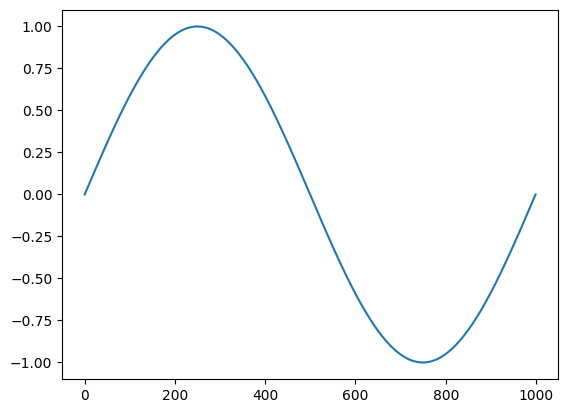

In [82]:
plt.plot(sin_func(x, 1, 1, 0))

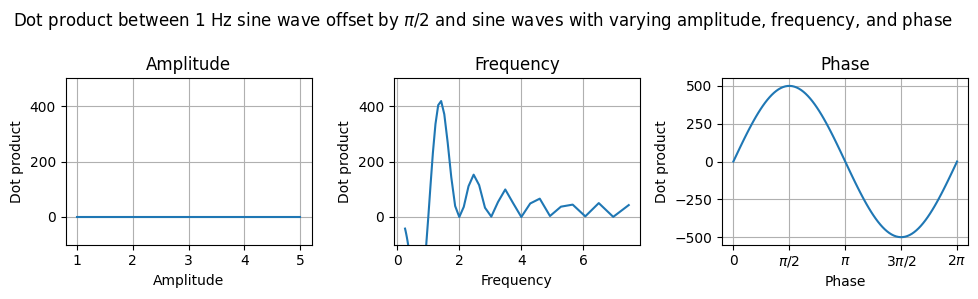

In [83]:
ref_cos = cos_func(x, 1, 1, 0) # 1 Hz cosine wave

var_a = [np.dot(ref_cos, sin_func(x, a, 1, 0)) for a in range(1, 6)]
var_f = [np.dot(ref_cos, sin_func(x, 1, f, 0)) for f in np.power(2.0, np.arange(-2, 3, 0.1))]
var_p = [np.dot(ref_cos, sin_func(x, 1, 1, p)) for p in np.linspace(0, 2*np.pi, 100)]

# plot the dot products
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].plot(range(1, 6), var_a)
ax[0].set_ylim([-100, 500])
ax[0].set_xlabel('Amplitude')
ax[0].set_ylabel('Dot product')
ax[0].set_title('Amplitude')
ax[0].grid()
ax[1].plot(np.power(2.0, np.arange(-2, 3, 0.1)), var_f)
ax[1].set_ylim([-100, 500])
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Dot product')
ax[1].set_title('Frequency')
ax[1].grid()
ax[2].plot(np.linspace(0, 2*np.pi, 100), var_p)
ax[2].set_xticks(np.linspace(0, 2*np.pi, 5))
ax[2].set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
#ax[2].set_yticks(np.arange(-500, 501, 250))
ax[2].set_xlabel('Phase')
ax[2].set_ylabel('Dot product')
ax[2].set_title('Phase')
ax[2].grid()
fig.suptitle('Dot product between 1 Hz sine wave offset by $\pi/2$ and sine waves with varying amplitude, frequency, and phase')
fig.tight_layout()

Inspecting the phase plot, we can now detect when the signal sine wave is offset by $\pi/2$, but we still have the problem with dot products with a value of 0, just now at multiples of $\pi$. Since all our signals had an offset of 0, this means none of them are detectable with a cosine wave. This is evident in the Amplitude and Frequency plots, which are all zeros. 

If we want to detect whether a sine wave is present, irrespective of its phase offset, we need to combine the sine and cosine dot products. To get of sense of how to combine these, let's redo the phase plot, but this time have the dot product for sin plotted on the y-axis, and cosine on the x-axis.

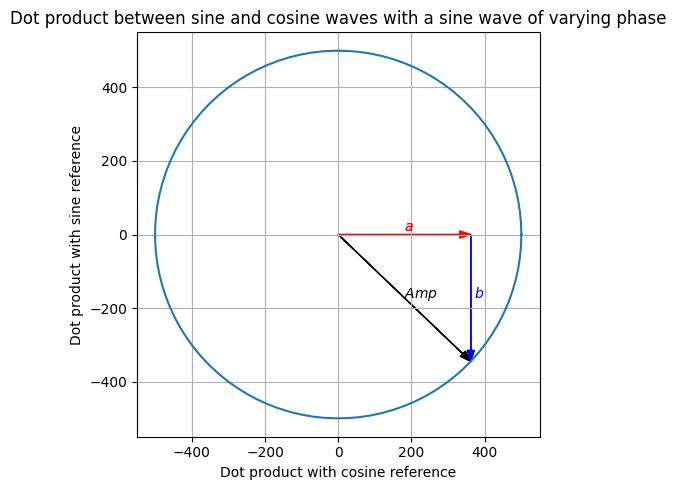

In [95]:
# vary the phase of the signal and calculate its dot product with the sine and cosine reference signals
var_p_sin = [np.dot(ref_sin, cos_func(x, 1, 1, p)) for p in np.linspace(0, 2*np.pi, 100)]
var_p_cos = [np.dot(ref_cos, cos_func(x, 1, 1, p)) for p in np.linspace(0, 2*np.pi, 100)]

disp_p = np.abs(np.linspace(0, 2*np.pi, 100) - np.pi/4).argmin()

# plot the dot products as a function of phase on a circular plot
plt.figure(figsize=(5, 5))
plt.plot(var_p_cos, var_p_sin)
plt.arrow(0, 0, var_p_cos[disp_p], var_p_sin[disp_p], width=0.05, head_width=20, color='k', length_includes_head=True)
plt.text(var_p_cos[disp_p]/2, var_p_sin[disp_p]/2, '$Amp$', fontsize=10, color='k')
plt.arrow(0, 0, var_p_cos[disp_p], 0, width=0.05, head_width=20, color='r', length_includes_head=True)
plt.text(var_p_cos[disp_p]/2, 10, '$a$', fontsize=10, color='r')
plt.arrow(var_p_cos[disp_p], 0, 0, var_p_sin[disp_p], width=0.05, head_width=20, color='b',  length_includes_head=True)
plt.text(var_p_cos[disp_p]/2, 10, '$a$', fontsize=10, color='r')
plt.text(var_p_cos[disp_p]+10, var_p_sin[disp_p]/2, '$b$', fontsize=10, color='b')
plt.grid()
plt.xlabel('Dot product with cosine reference')
plt.ylabel('Dot product with sine reference')
plt.title('Dot product between sine and cosine waves with a sine wave of varying phase')
plt.tight_layout()


Notice that a circle is drawn. The radius of that circle is constant, irrespective of the phase difference between the oscillations. Normally we will only be presenting one signal, so we cannot sample the full circle. But, if we know the dot product for the sine and cosine refernces, we can calculate it using the Euclidean distance:

$$ 
Amp = \sqrt{a^2 + b^2}
$$

Let's see if this gives us a consistent answer.

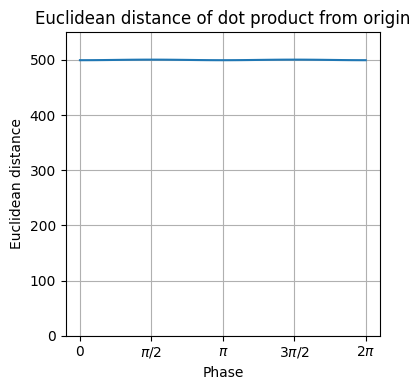

In [29]:
# calculate the euclidean distance of the dot products from the origin
dist = np.sqrt(np.power(var_p_sin, 2) + np.power(var_p_cos, 2))
plt.figure(figsize=(4, 4))
plt.plot(np.linspace(0, 2*np.pi, 100), dist)
plt.ylim([0, 550])
plt.xticks(np.linspace(0, 2*np.pi, 5), ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.grid()
plt.xlabel('Phase')
plt.ylabel('Euclidean distance')
plt.title('Euclidean distance of dot product from origin')
plt.tight_layout()

Great, so now we have a way to measure the amplitude of a sinusoidal wave irrespective of its phase. The next thing we want to measure with spectral analysis is the phase. This too can be derived from the $a$ and $b$ parameters. We measure the angle with respect to the x-axis as:

$$ phase = \arctan{\left(\frac{b}{a}\right)} $$

This becomes clearer if you consider the $a$ and $b$ components as sides of a triangle.

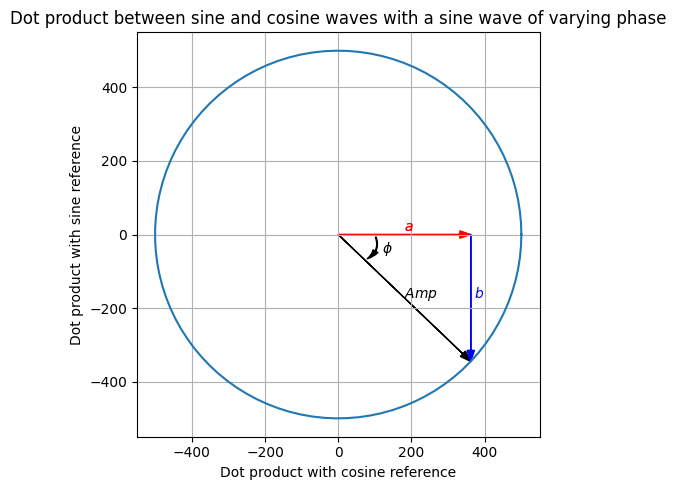

In [109]:
# plot the dot products as a function of phase on a circular plot
# plot the dot products as a function of phase on a circular plot
plt.figure(figsize=(5, 5))
plt.plot(var_p_cos, var_p_sin)
plt.arrow(0, 0, var_p_cos[disp_p], var_p_sin[disp_p], width=0.05, head_width=20, color='k', length_includes_head=True)
plt.text(var_p_cos[disp_p]/2, var_p_sin[disp_p]/2, '$Amp$', fontsize=10, color='k')
plt.arrow(0, 0, var_p_cos[disp_p], 0, width=0.05, head_width=20, color='r', length_includes_head=True)
plt.text(var_p_cos[disp_p]/2, 10, '$a$', fontsize=10, color='r')
plt.arrow(var_p_cos[disp_p], 0, 0, var_p_sin[disp_p], width=0.05, head_width=20, color='b',  length_includes_head=True)
plt.text(var_p_cos[disp_p]/2, 10, '$a$', fontsize=10, color='r')
plt.text(var_p_cos[disp_p]+10, var_p_sin[disp_p]/2, '$b$', fontsize=10, color='b')
# draw curved arrow at the angle of the dot product
arrow = FancyArrowPatch((100, 0), (var_p_cos[disp_p]/5, var_p_sin[disp_p]/5), arrowstyle='Simple,tail_width=0.5,head_width=4,head_length=8', color='k', connectionstyle='arc3,rad=-.5')
# label arrow with the phase
plt.text(120, -50, '$\phi$', fontsize=10, color='k')
plt.gca().add_patch(arrow)
plt.grid()
plt.xlabel('Dot product with cosine reference')
plt.ylabel('Dot product with sine reference')
plt.title('Dot product between sine and cosine waves with a sine wave of varying phase')
plt.tight_layout()

Let' calculate the angle now.

In [112]:
phase = np.arctan(var_p_sin[disp_p]/var_p_cos[disp_p])
print("Phase of dot product: {:.2f} degrees".format(180*(phase/np.pi)))

Phase of dot product: -43.58 degrees


Instead of returning two seperate numbers ($a$ and $b$) for each frequency, we combine these into a single *complex number*. To briefly refresh, complex numbers have two components, a real part that lies along the x-axis, and an imaginary component that lies along the y-axis. The $a$ component associated with the cosine is the real part, and the $b$ component associated with sine is the imaginary component.

Numpy supports complex numbers, along with the math that can be applied to them.

In [132]:
s = complex(var_p_cos[disp_p], var_p_sin[disp_p])

print("Complex number: {:.2f} + {:.2f}i".format(s.real, s.imag))
print("Magnitude of dot product using np.abs: {:.2f}".format(np.abs(s)))
print("Phase of dot product using np.angle: {:.2f} radians".format(np.angle(s)))


Complex number: 362.23 + -344.69i
Magnitude of dot product using np.abs: 500.02
Phase of dot product using np.angle: -0.76 radians


So far we have done this for just a single reference frequency. But signals we record in the brain can be decomposed into multiple sinusoids.

The Fourier transform acheives this. It takes a signal that is defined as varying across time and translates it into the frequency domain, where signal varies across frequencies. Put another way, we can describe a time series $y(t)$ as a series of real values at different times $t$, $[y_0, y_1, y_2, ..., y_n]$, where $n$ is the number of time points. The frequency domain representation of that signal, $Y(f)$, is a series of complex values at different frequencies, $[Y_0, Y_1, Y_2, ..., Y_n]$, where n is the number of frequencies. Since we are dealing with digitized signals that are sampled at a fixed rate and for a finite amount of time, we will use the *discrete Fourier transformation* (DFT). The DFT can be written as:

$$ \begin{align}
    \notag Y(f) &= a + bi \\
    \notag Y(f) &= y \cdot cos(2\pi f t) + y \cdot sin(2\pi f t)i \\
    \notag Y(f) &= \sum_{t=0}^{n}y(t)cos(2\pi f t) + y(t)sin(2\pi f t)i \\
    \end{align}
$$

We will refer to $Y(f)$ as a spectrum. The frequencies, $f$, that make up the spectrum are determined by the duration of the signal and sample rate. The minimum frequency we can measure is 0, which is just the mean value of the signal. We then increase from 0 in steps of $1/T$, where $T$ is the duration of the signal. To unambiguously measure the presence of a sinusoid, you need to have at least one full cycle of it. Thus, a sinusoid with a frequency of $1/T$ will have the smallest frequency that can be measured. We then increase the frequency in steps of $1/T$, for as many time points as there are in the signal. For instance, if we record a signal for 1 second, and sample at a rate of 1kHz, that gives us a frequency step of $1/1 sec = 1 Hz$. With 1000 samples, that means we have up to 1000 Hz. Let's try to code this.

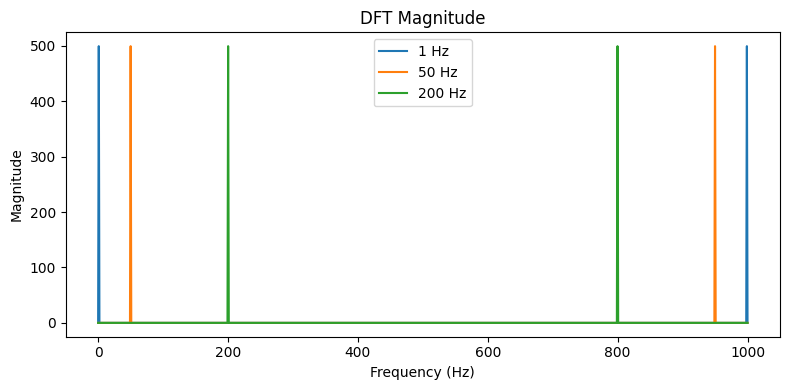

In [131]:
# discrete fourier transform function
def dft(y, fs=1000):
    """
    Calculates the discrete fourier transform of a signal.
    
    Parameters
    ----------
    y : array_like
        The signal to calculate the DFT for.
    fs : float
        The sampling rate of the signal.
    
    Returns
    -------
    f : array_like
        The frequency vector.
    Y : array_like
        The DFT of the signal.
    """

    # get the length of the signal
    N = len(y)
    f = np.linspace(0, fs, N)
                    
    # initialize the DFT vector
    Y = np.zeros(N, dtype=complex)

    # create the time vector
    t = np.arange(N)/fs

    # calculate the DFT
    for k in range(N):
        Y[k] = complex(np.dot(y, np.cos(2*np.pi*f[k]*t)), -np.dot(y, np.sin(2*np.pi*f[k]*t)))
    return f, Y

# create test signals with different frequencies
x = np.linspace(0, 1, 1000)
test_sin1 = sin_func(x, 1, 1, 0)
test_sin2 = sin_func(x, 1, 50, 0)
test_sin3 = sin_func(x, 1, 200, 0)

# calculate the DFT of the test signals
f, Y_sin1 = dft(test_sin1)
f, Y_sin2 = dft(test_sin2)
f, Y_sin3 = dft(test_sin3)

# plot the DFT
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(f, np.abs(Y_sin1))
ax.plot(f, np.abs(Y_sin2))
ax.plot(f, np.abs(Y_sin3))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('DFT Magnitude')
ax.legend(['1 Hz', '50 Hz', '200 Hz'])
fig.tight_layout()

We can see that each spectrum shows a single peak at the frequency of the sine wave we created, either 1, 50, or 200 Hz. However, we also see that these are mirrored above 500 Hz. The DFT found an 800 Hz wave with the 200 Hz signal, a 950 Hz wave at the 50 Hz signal, and a 999 Hz signal with the 1 Hz signal. The reasons for this are a bit beyond this course, but put simply arise because sinusoids greater than one half of the sample rate (here 500 Hz) cannot be adequately identified and in fact can be spuriously detected. Thus, we usually cut off the spectrum at half the sample rate, commonly referred to as the Nyquist frequency.

What happens if we have multiple sine waves combined together for our signal?

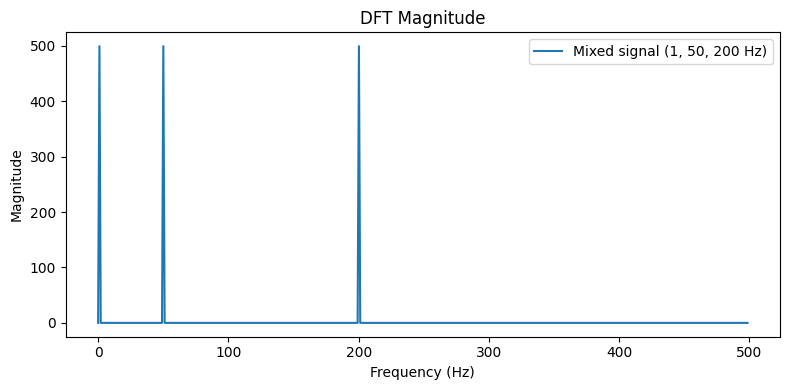

In [136]:
test_sinmixed = test_sin1 + test_sin2 + test_sin3

# calculate the DFT of the test signals
f, Y_sinmixed = dft(test_sinmixed)

nyq_ind = np.argmin(np.abs(f-fs/2))

# plot the DFT
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(f[:nyq_ind], np.abs(Y_sinmixed[:nyq_ind]))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('DFT Magnitude')
ax.legend(['Mixed signal (1, 50, 200 Hz)'])
fig.tight_layout()

It works!

In [10]:
#freqs, times, Sxx = ss.spectrogram(ecog['data'][:, 38], fs, nperseg=256, noverlap=200)
# use scipy.signal.spectrogram to get the spectrogram for each ecog channel
# store as a numpy array with dimensions (freqs, time, channels)
spec = []
for ch in ch_list:
    freqs, t_spec, Sxx = ss.spectrogram(ecog['data'][:, ch], fs, nperseg=256, noverlap=200, window='hamming')
    spec.append(Sxx.T) # transpose to get (time, freqs)
spec = np.dstack(spec)
spec.shape

(10890, 129, 63)

In [14]:
# create a new array of fl events at the time points closest to those in the spectrogram data
fl_spec = np.zeros((spec.shape[0], fl.shape[1])).astype(int)

for i,t in enumerate(t_spec):
    fl_spec[i] = fl[np.argmin(np.abs(t_raw - t))]

In [15]:
sel_flex = 0

In [19]:
plot_chan = 20
plot_trial = 12
pre_t = 1.5 # seconds
post_t = 1.5 # seconds

In [60]:
# preprocess spectrogram data
spec_pro = zscore(spec, 0)

# get the spectrogram data for each event
fs_spec = 1/np.mean(np.diff(t_spec))
pre = int(pre_t*fs_spec)
post = int(post_t*fs_spec)
spec_events = []
for i, o in enumerate(onsets_spec):
    spec_events.append(spec_pro[(o-pre):(o+post), :, :])
spec_events = np.stack(spec_events, axis=3)


null_spec_events = []
for i, o in enumerate(onsets_spec+(2*fs_spec).astype(int)):
    null_spec_events.append(spec_pro[(o-pre):(o+post), :, :])
null_spec_events = np.stack(null_spec_events, axis=3)

spec_mean = np.mean(spec_events, axis=3)
null_spec_mean = np.mean(null_spec_events, axis=3)
spec_events_t = np.linspace(-pre_t, post_t, pre+post)

In [73]:
spec_events.shape

(52, 129, 63, 47)

In [105]:
sel_freqs = np.where((freqs>40)&(freqs<150))[0]

In [106]:
sel_t = np.where((spec_events_t>-0)&(spec_events_t<0.5))[0]
sel_t.dtype

dtype('int64')

In [76]:
sel_t[0]:sel_t[-1]


(array([ 7., 10., 13.,  4.,  3.,  4.,  3.,  0.,  2.,  1.]),
 array([-0.27501653, -0.14470787, -0.01439922,  0.11590944,  0.2462181 ,
         0.37652676,  0.50683542,  0.63714407,  0.76745273,  0.89776139,
         1.02807005]),
 <BarContainer object of 10 artists>)

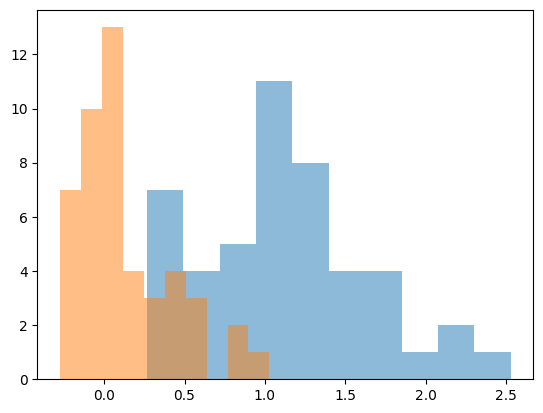

In [107]:
flex_resp = np.mean(spec_events[sel_t[0]:sel_t[-1], sel_freqs[0]:sel_freqs[-1], plot_chan, :], axis=(0,1))
null_resp = np.mean(null_spec_events[sel_t[0]:sel_t[-1], sel_freqs[0]:sel_freqs[-1], plot_chan, :], axis=(0,1))

plt.hist(flex_resp, alpha=0.5, label='flex')
plt.hist(null_resp, alpha=0.5, label='null')

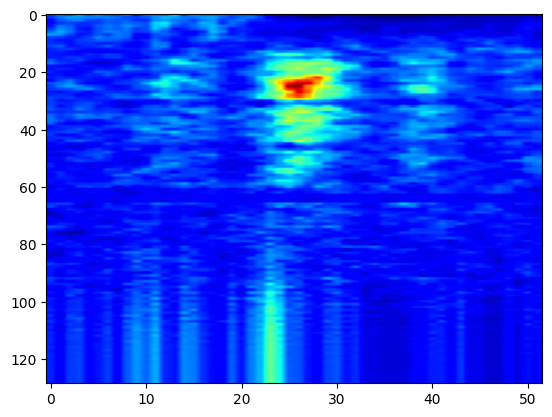

In [70]:
plt.imshow( spec_mean[:,:, plot_chan].T, aspect='auto', cmap='jet')

In [83]:
# preprocess ecog data
ecog_pro = zscore(ecog['data'], 0)

# calculate the mean evoked response at the event onset times
fs = 1000
pre = int(1.5*fs)
post = int(1.5*fs)
events = []
for i, o in enumerate(onsets):
    events.append(ecog_pro[(o-pre):(o+post), :])
events = np.stack(events, axis=2)

# get epochs 2 seconds offset from the event onset
null_events = []
for i, o in enumerate((onsets+(2.3*fs)).astype(int)):
    null_events.append(ecog_pro[(o-pre):(o+post), :])
null_events = np.stack(null_events, axis=2)

# calculate the mean evoked response at the event onset times
events_mean = np.mean(events, axis=2)
null_events_mean = np.mean(null_events, axis=2)
t = np.linspace(-pre_t, post_t, pre+post)


In [22]:
events.shape

(3000, 63, 47)

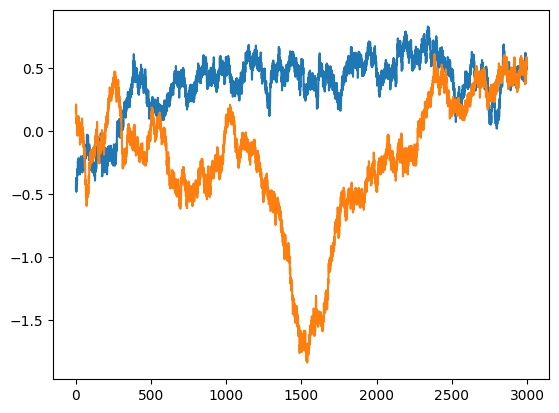

In [23]:
plt.plot(null_events_mean[:, plot_chan])
plt.plot(events_mean[:, plot_chan])

In [24]:
car = np.median(events,1)
car = car[:, np.newaxis, :]
car.shape

(3000, 1, 47)

In [87]:
erp_decode = ERP_Decode_SK(k=3, rand_seed=10)
epochs = np.vstack([events[:,plot_chan,:].T, null_events[:,plot_chan,:].T])
labels = np.hstack([np.ones(events.shape[2]), np.zeros(null_events.shape[2])])
erp_decode.fit(epochs, labels)


(96.7741935483871, 96.875)

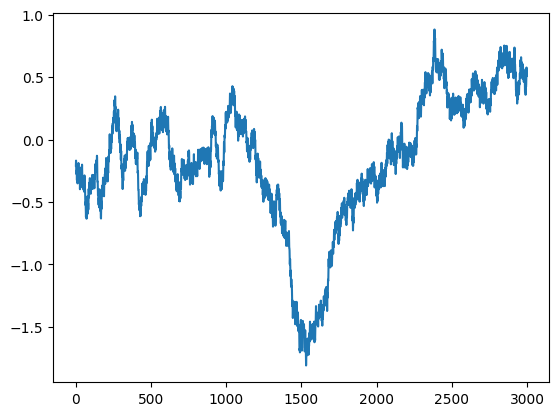

In [48]:
plt.plot(erp_decode.erp)

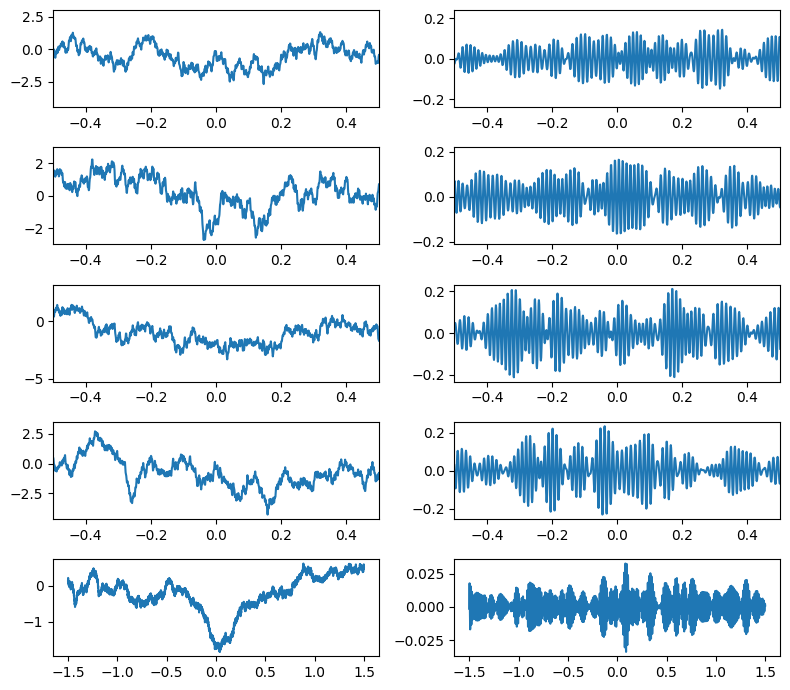

In [214]:
b, a = ss.butter(4, [70, 90], 'bandpass', fs=fs) # create the filter coefficients
events_filt = ss.filtfilt(b, a, events, axis=0) # filter the data

examp_trials = np.array([0, 1, 2, 3])
z_range = 5
mos_layout = [['ecog1', 'filt1'], ['ecog2', 'filt2'], ['ecog3', 'filt3'], ['ecog4', 'filt4'], ['ecog_mean', 'filt_mean']]
fig, ax = plt.subplot_mosaic(mos_layout, figsize=(8, 7))
for i, tr in enumerate(examp_trials):
    ax['ecog{}'.format(i+1)].plot(t, events[:, plot_chan, tr])    
    ax['ecog{}'.format(i+1)].set_xlim(-.5, .5)
    ax['filt{}'.format(i+1)].plot(t, events_filt[:, plot_chan, tr])    
    ax['filt{}'.format(i+1)].set_xlim(-.5, .5)

ax['ecog_mean'].plot(t, np.mean(events[:, plot_chan, :], axis=1))
ax['filt_mean'].plot(t, np.mean(events_filt[:, plot_chan, :], axis=1))
fig.tight_layout()

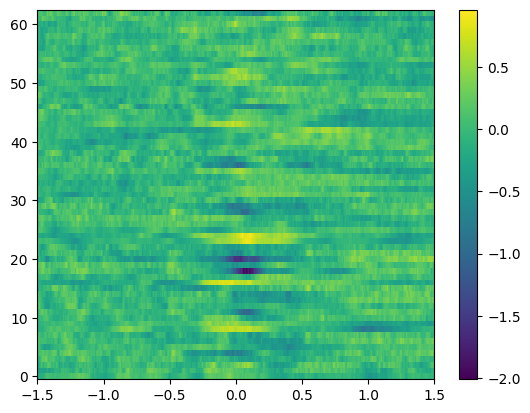

In [95]:
# plot mean ERP across electrodes
pmesh = plt.pcolormesh(t, np.arange(0, 63), np.mean(events-car,axis=2).T)
plt.colorbar(pmesh)

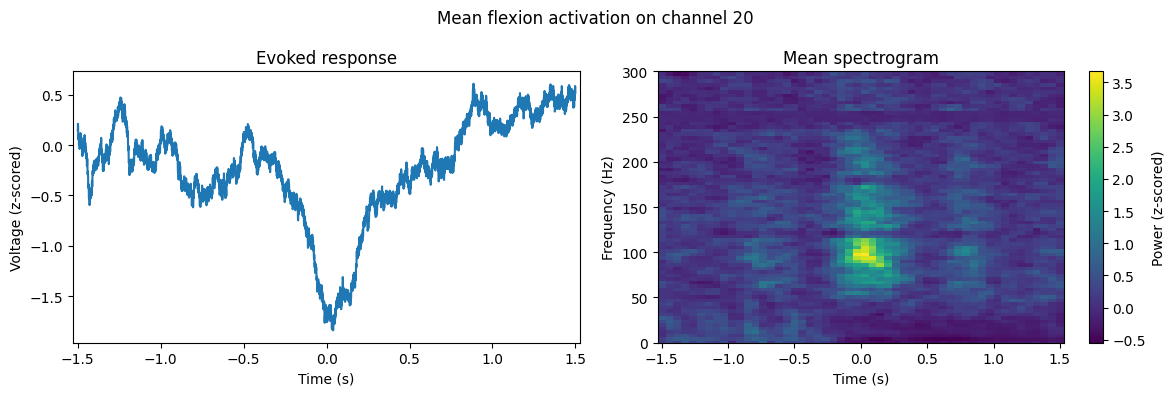

In [147]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(12, 4))
ax[0].plot(t, events_mean[:, plot_chan])
ax[0].set_ylabel('Voltage (z-scored)')
ax[0].set_xlabel('Time (s)')
ax[0].set_title('Evoked response')
pmesh = ax[1].pcolormesh(spec_events_t, freqs, spec_mean[:,:,plot_chan].T)
ax[1].set_ylim(0, 300)
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Mean spectrogram')
cbar = plt.colorbar(pmesh)
cbar.set_label('Power (z-scored)')
fig.suptitle('Mean flexion activation on channel {}'.format(plot_chan))
fig.tight_layout()


In [215]:
print(events.shape)
events_none = events[0,1,:]

(3000, 63, 47)

In [216]:
spec_events.shape

(52, 129, 63, 47)

In [110]:
10**1.7

50.11872336272722

In [184]:
spec_events[:,:,plot_chan,tr].shape

(52, 129)

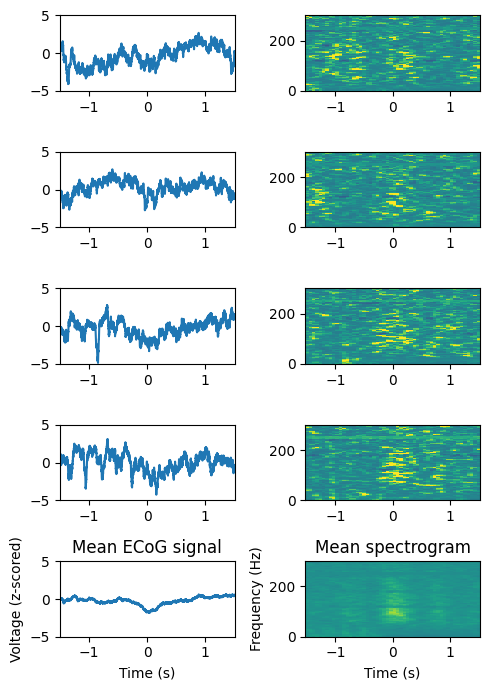

In [203]:
examp_trials = np.array([0, 1, 2, 3])
z_range = 5
mos_layout = [['ecog1', 'spec1'], ['ecog2', 'spec2'], ['ecog3', 'spec3'], ['ecog4', 'spec4'], ['ecog_mean', 'spec_mean']]
fig, ax = plt.subplot_mosaic(mos_layout, figsize=(5, 7))
for i, tr in enumerate(examp_trials):
    ax['ecog{}'.format(i+1)].plot(t, events[:, plot_chan, tr])    
    ax['ecog{}'.format(i+1)].set_ylim(-z_range, z_range)
    ax['ecog{}'.format(i+1)].set_xlim(-1.5, 1.5)
    ax['spec{}'.format(i+1)].pcolormesh(spec_events_t, freqs, spec_events[:,:,plot_chan,tr].T, vmin=-z_range, vmax=z_range)
    ax['spec{}'.format(i+1)].set_ylim(0, 300)


ax['ecog_mean'].plot(t, np.mean(events[:, plot_chan, :], axis=1))
ax['spec_mean'].pcolormesh(spec_events_t, freqs, np.mean(spec_events[:,:,plot_chan,:], axis=2).T, vmin=-z_range, vmax=z_range)
ax['ecog_mean'].set_ylim(-z_range, z_range)
ax['ecog_mean'].set_xlim(-1.5, 1.5)

ax['ecog_mean'].set_ylabel('Voltage (z-scored)')
ax['ecog_mean'].set_xlabel('Time (s)')
ax['ecog_mean'].set_title('Mean ECoG signal')
ax['spec_mean'].set_ylim(0, 300)
ax['spec_mean'].set_ylabel('Frequency (Hz)')
ax['spec_mean'].set_xlabel('Time (s)')
ax['spec_mean'].set_title('Mean spectrogram')
fig.tight_layout()

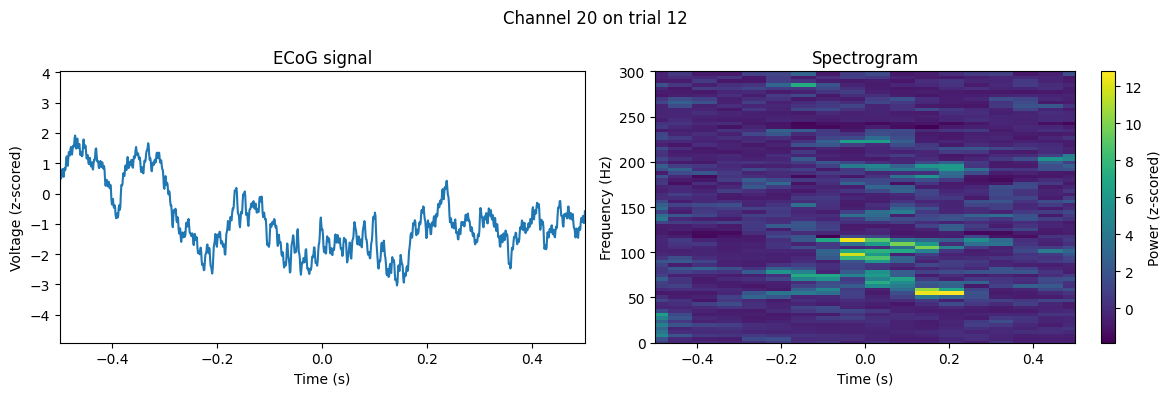

In [158]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(12, 4))
ax[0].plot(t, events[:, plot_chan, plot_trial])
ax[0].set_title('ECoG signal')
ax[0].set_ylabel('Voltage (z-scored)')
ax[0].set_xlabel('Time (s)')
ax[0].set_xlim(-0.5,0.5)
pmesh = ax[1].pcolormesh(spec_events_t, freqs, spec_events[:,:,plot_chan,plot_trial].T)
ax[1].set_ylim(0, 300)
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Spectrogram')
cbar = plt.colorbar(pmesh)
cbar.set_label('Power (z-scored)')
fig.suptitle('Channel {} on trial {}'.format(plot_chan,plot_trial))
fig.tight_layout()

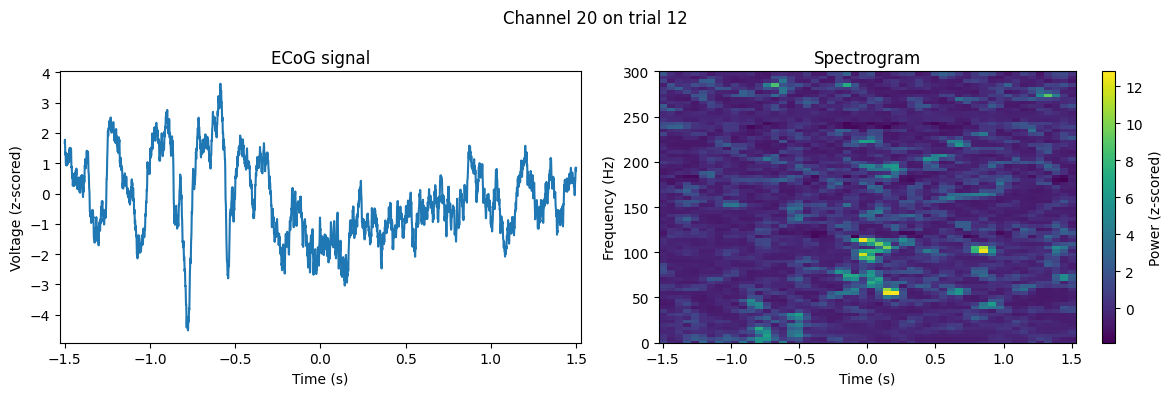

In [148]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(12, 4))
ax[0].plot(t, events[:, plot_chan, plot_trial])
ax[0].set_title('ECoG signal')
ax[0].set_ylabel('Voltage (z-scored)')
ax[0].set_xlabel('Time (s)')
pmesh = ax[1].pcolormesh(spec_events_t, freqs, spec_events[:,:,plot_chan,plot_trial].T)
ax[1].set_ylim(0, 300)
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Spectrogram')
cbar = plt.colorbar(pmesh)
cbar.set_label('Power (z-scored)')
fig.suptitle('Channel {} on trial {}'.format(plot_chan,plot_trial))
fig.tight_layout()


Text(0.5, 1.0, 'Power in 50-150 Hz')

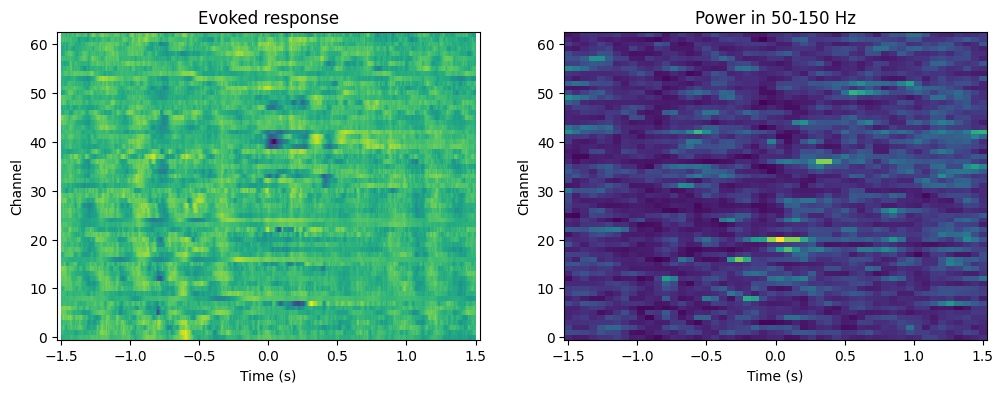

In [159]:
# plot ERP for specific trials
f_inds = np.where((freqs>50) & (freqs<150))[0]
fig, ax = plt.subplots(1,2, sharex=True, figsize=(12, 4))
ax[0].pcolormesh(t, ch_list, events[:,:,plot_trial].T)
ax[0].set_ylabel('Channel')
ax[0].set_xlabel('Time (s)')
ax[0].set_title('Evoked response')
ax[1].pcolormesh(spec_events_t, ch_list, np.mean(spec_events[:,f_inds,:,plot_trial],axis=0).T)
ax[1].set_ylabel('Channel')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Power in 50-150 Hz')

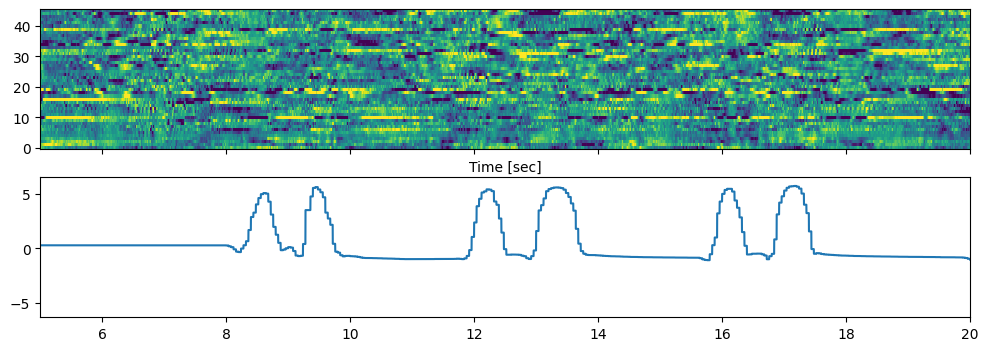

In [124]:
t_flex = np.arange(0, ecog['flex'].shape[0])/fs
# plot the spectrogram
fig, ax = plt.subplots(2,1,figsize=(12, 4),sharex=True)
# image plot of ecog multichannel data
ax[0].pcolormesh(t_flex, np.arange(0, ecog['data'].shape[1]), zscore(ecog['data'].T, 0), vmin=-2, vmax=2)
#ax[0].pcolormesh(times, freqs, zscore(np.log10(Sxx), 1), vmin=-2, vmax=2)
#ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
#ax[0].set_ylim(0, 100)
ax[0].set_xlim(5, 20)
ax[1].plot(t_flex, zscore(ecog['flex'][:, 4], 0))
plt.show()
